Imports

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Load and preprocess dataset

In [2]:
# Load the data from the specified CSV file and then set everything as floats

data = np.genfromtxt('dataset/processed.cleveland.data', delimiter=',', dtype=str)

# Set all missing values to NaN
data[data == '?'] = np.nan
data = data.astype(float)

Remove rows with missing values

In [3]:
# Find all rows that do not contain missing values and keep indices

rows_without_nan = ~np.isnan(data).any(axis=1)

# Remove all rows with missing values
cleaned_data = data[rows_without_nan]

# Get all the labels and set all values greater than 0 to 1
labels = cleaned_data[:, -1]

for i in range(len(labels)):
    if labels[i] > 0:
        labels[i] = 1

cleaned_data = cleaned_data[:, :-1]

Standard Normalize

In [4]:
mean = np.mean(cleaned_data)
std_dev = np.std(cleaned_data)
z_score = (cleaned_data - mean) / std_dev

PCA

Explained Variance:  [7.46243578e-01 1.49787648e-01 8.57955289e-02 1.60023313e-02
 1.01307682e-03 3.30072242e-04 2.50801576e-04 2.22000205e-04
 1.76402998e-04 5.92782847e-05 4.75020518e-05 4.06039465e-05
 3.11751680e-05]


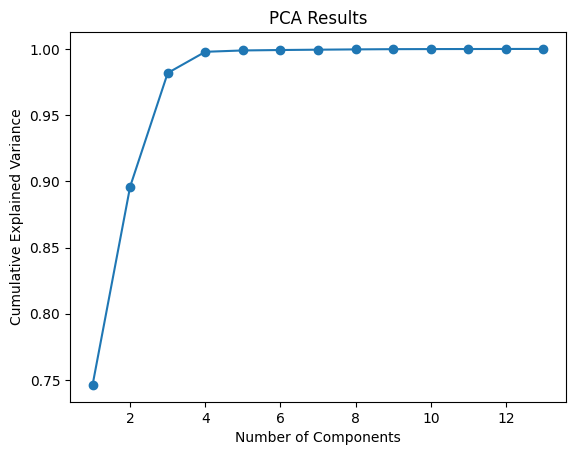

In [5]:
# Get 13 principal components, so we have a component for every feature

# Fit PCA model
pca = PCA(n_components=13)
principal_components =  pca.fit_transform(cleaned_data)

# Collect the explained variance by each principal component

explained_variance = pca.explained_variance_ratio_
print("Explained Variance: ", explained_variance)

# Find the cumulative explained variance for each component

cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative variance explained by each component

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Results')
plt.show()


Plot a dimensioned reduced dataset

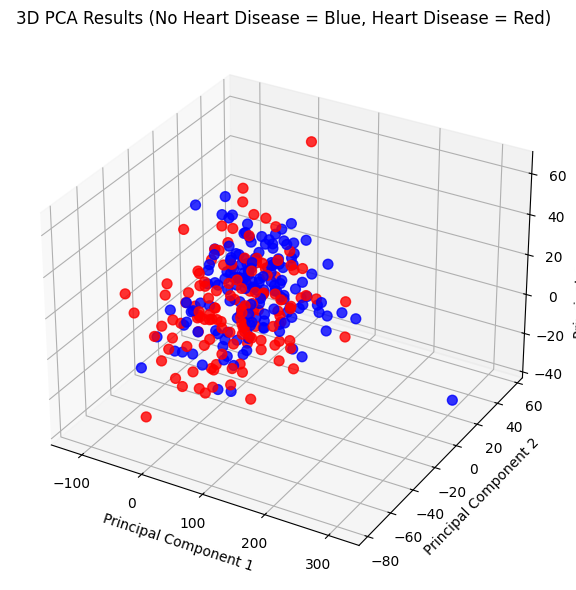

In [6]:
# Set all instances of heart disease as red and all labels for no heart disease as blue
colors = np.array(['blue' if label == 0 else 'red' for label in labels])

# Create a 3d scatter plot of the first 3 principle components

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    principal_components[:, 2],
    color=colors,
    s=50,
    alpha=0.8
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Results (No Heart Disease = Blue, Heart Disease = Red)')

plt.tight_layout()
plt.show()

Calculate silhouette score from ground truth to understand clustering possibilities

In [7]:
score = silhouette_score(cleaned_data, labels)
print("Silhouette: ", score)

Silhouette:  0.04435317118377064


KMEANS no dimension reduction

2-cluster KMeans accuracy: 48.33%
3-cluster KMeans accuracy: 43.33%
4-cluster KMeans accuracy: 56.67%
5-cluster KMeans accuracy: 51.67%
6-cluster KMeans accuracy: 58.33%
7-cluster KMeans accuracy: 53.33%
8-cluster KMeans accuracy: 56.67%
9-cluster KMeans accuracy: 58.33%
10-cluster KMeans accuracy: 56.67%
11-cluster KMeans accuracy: 63.33%
12-cluster KMeans accuracy: 63.33%
13-cluster KMeans accuracy: 63.33%
14-cluster KMeans accuracy: 51.67%
15-cluster KMeans accuracy: 48.33%
16-cluster KMeans accuracy: 58.33%
17-cluster KMeans accuracy: 56.67%
18-cluster KMeans accuracy: 55.00%
19-cluster KMeans accuracy: 53.33%
20-cluster KMeans accuracy: 55.00%
21-cluster KMeans accuracy: 56.67%
22-cluster KMeans accuracy: 56.67%
23-cluster KMeans accuracy: 63.33%
24-cluster KMeans accuracy: 63.33%
25-cluster KMeans accuracy: 60.00%
26-cluster KMeans accuracy: 56.67%
27-cluster KMeans accuracy: 56.67%
28-cluster KMeans accuracy: 53.33%
29-cluster KMeans accuracy: 53.33%
30-cluster KMeans accuracy: 

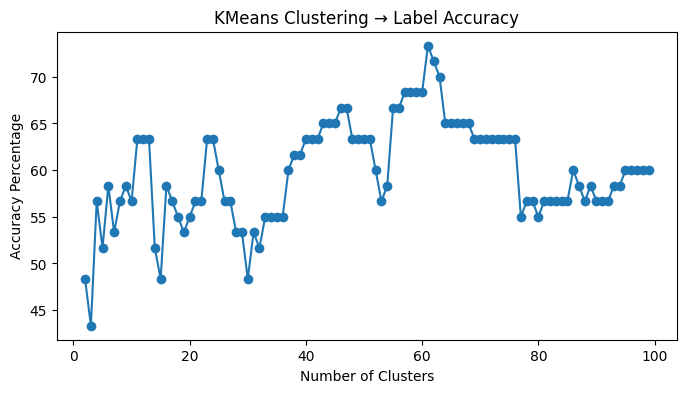

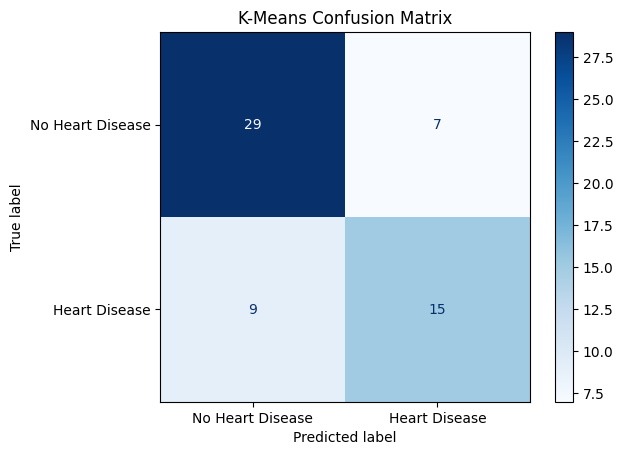

In [12]:
# Set up train test split for evaluating KMEANS

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_data, labels.astype(int), test_size=0.2, random_state=42
)

accuracy_vals = []
# Set up values to test for number of clusters
cluster_range = range(2, 100)

best_accuracy = 0
best_num_clusters = None

# Perform search to find optimal number of clusters

for k in cluster_range:
    
    # Fit KMEANS model to number of clusters
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)
    train_clusters = kmeans.labels_

    # Map clusters to ground truth by finding most common ground truth label 

    mapping = {}
    for c in np.unique(train_clusters):
        mask = (train_clusters == c)
        mapping[c] = np.bincount(y_train[mask]).argmax()

    # Test model accuracy off of clusters

    test_clusters = kmeans.predict(X_test)
    
    # Get predictions mapped to ground truth
    
    y_pred = np.array([ mapping[c] for c in test_clusters ])

    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_num_clusters = k
        
    accuracy_vals.append(acc)
    print(f"{k}-cluster KMeans accuracy: {acc:.2%}")

# Plot number of clusters vs. accuracy

plt.figure(figsize=(8,4))
accuracy_vals = np.array(accuracy_vals) * 100
plt.plot(list(cluster_range), accuracy_vals, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy Percentage")
plt.title("KMeans Clustering → Label Accuracy")
plt.show()

kmeans = KMeans(n_clusters=best_num_clusters, random_state=42).fit(X_train)
train_clusters = kmeans.labels_

# Map clusters to ground truth by finding most common ground truth label 

mapping = {}
for c in np.unique(train_clusters):
    mask = (train_clusters == c)
    mapping[c] = np.bincount(y_train[mask]).argmax()

# Test model accuracy off of clusters

test_clusters = kmeans.predict(X_test)

# Get predictions mapped to ground truth

y_pred = np.array([ mapping[c] for c in test_clusters ])

cm = confusion_matrix(y_test, y_pred)

class_names = ['No Heart Disease', 'Heart Disease']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues')
plt.title("K-Means Confusion Matrix")
plt.show()



KMEANS on PCA

2-cluster KMeans accuracy: 48.33%
3-cluster KMeans accuracy: 43.33%
4-cluster KMeans accuracy: 56.67%
5-cluster KMeans accuracy: 51.67%
6-cluster KMeans accuracy: 55.00%
7-cluster KMeans accuracy: 56.67%
8-cluster KMeans accuracy: 51.67%
9-cluster KMeans accuracy: 50.00%
10-cluster KMeans accuracy: 51.67%
11-cluster KMeans accuracy: 53.33%
12-cluster KMeans accuracy: 53.33%
13-cluster KMeans accuracy: 60.00%
14-cluster KMeans accuracy: 58.33%
15-cluster KMeans accuracy: 61.67%
16-cluster KMeans accuracy: 55.00%
17-cluster KMeans accuracy: 58.33%
18-cluster KMeans accuracy: 58.33%
19-cluster KMeans accuracy: 65.00%
20-cluster KMeans accuracy: 61.67%
21-cluster KMeans accuracy: 51.67%
22-cluster KMeans accuracy: 48.33%
23-cluster KMeans accuracy: 58.33%
24-cluster KMeans accuracy: 58.33%
25-cluster KMeans accuracy: 58.33%
26-cluster KMeans accuracy: 56.67%
27-cluster KMeans accuracy: 56.67%
28-cluster KMeans accuracy: 58.33%
29-cluster KMeans accuracy: 58.33%
30-cluster KMeans accuracy: 

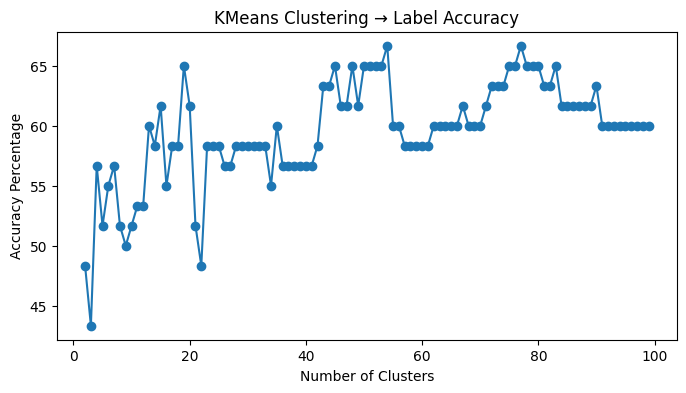

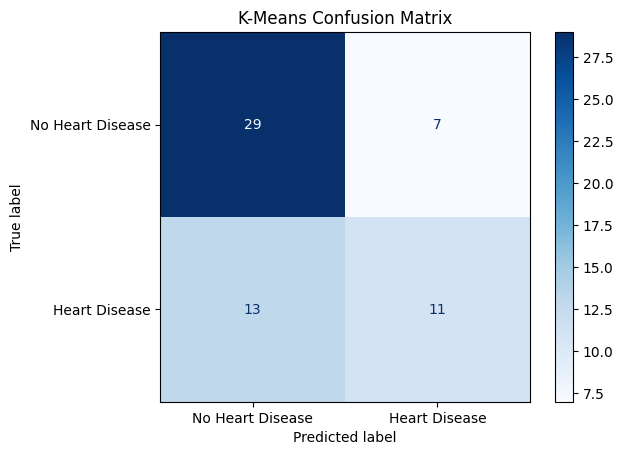

In [13]:
# Set up train test split with first 4 principal components

X_train, X_test, y_train, y_test = train_test_split(
    principal_components[:, :4], labels.astype(int), test_size=0.2, random_state=42
)

accuracy_vals = []
# Set up values to test for number of clusters
cluster_range = range(2, 100)

best_accuracy = 0
best_num_clusters = None

# Perform search to find optimal number of clusters

for k in cluster_range:
    
    # Fit KMEANS model to number of clusters
    
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)
    train_clusters = kmeans.labels_

    # Map clusters to ground truth by finding most common ground truth label 

    mapping = {}
    for c in np.unique(train_clusters):
        mask = (train_clusters == c)
        mapping[c] = np.bincount(y_train[mask]).argmax()

    # Test model accuracy off of clusters

    test_clusters = kmeans.predict(X_test)
    
    # Get predictions mapped to ground truth
    
    y_pred = np.array([ mapping[c] for c in test_clusters ])

    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_num_clusters = k
        
    accuracy_vals.append(acc)
    print(f"{k}-cluster KMeans accuracy: {acc:.2%}")

# Plot number of clusters vs. accuracy

plt.figure(figsize=(8,4))
accuracy_vals = np.array(accuracy_vals) * 100
plt.plot(list(cluster_range), accuracy_vals, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy Percentage")
plt.title("KMeans Clustering → Label Accuracy")
plt.show()

kmeans = KMeans(n_clusters=best_num_clusters, random_state=42).fit(X_train)
train_clusters = kmeans.labels_

# Map clusters to ground truth by finding most common ground truth label 

mapping = {}
for c in np.unique(train_clusters):
    mask = (train_clusters == c)
    mapping[c] = np.bincount(y_train[mask]).argmax()

# Test model accuracy off of clusters

test_clusters = kmeans.predict(X_test)

# Get predictions mapped to ground truth

y_pred = np.array([ mapping[c] for c in test_clusters ])

cm = confusion_matrix(y_test, y_pred)

class_names = ['No Heart Disease', 'Heart Disease']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues')
plt.title("K-Means Confusion Matrix")
plt.show()

Naive Bayes

Accuracy: 0.8833


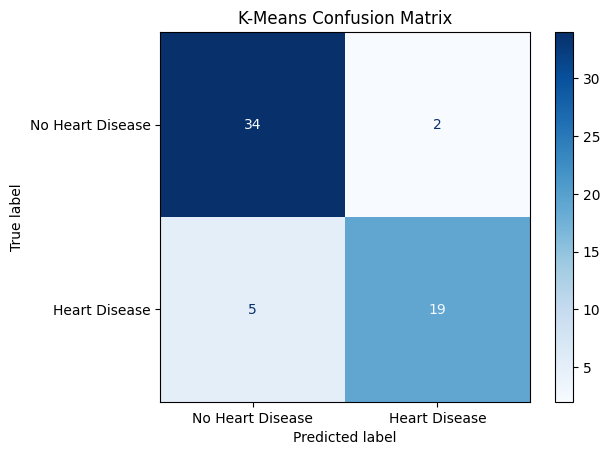

In [15]:
# Split continuous and categorical columns for plain and gaussian Naive Bayes
X_categorical_cols = [1, 2, 5, 8, 10, 12]
X_continuous_cols = [0, 3, 4, 6, 7, 9, 11]

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_data, labels.astype(int), test_size=0.2, random_state=42
)

# Split Columns based of indices

X_continuous_train = X_train[:, X_continuous_cols]
X_categorical_train = X_train[:, X_categorical_cols]
X_continuous_test = X_test[:, X_continuous_cols]
X_categorical_test = X_test[:, X_categorical_cols]

# Train models

gaussian_model = GaussianNB()
gaussian_model.fit(X_continuous_train, y_train)

categorical_model = CategoricalNB()
categorical_model.fit(X_categorical_train, y_train)

# Create predictions function that combines probabilities from gaussian and plain Naive Bayes

def predict_mixed_nb(X_continuous, X_categorical):
    
    # Get probabilities based off of continuous and categorical values
    
    gaussian_probs = gaussian_model.predict_proba(X_continuous)
    categorical_probs = categorical_model.predict_proba(X_categorical)
    
    # Combine probabilities
    
    combined_probs = gaussian_probs * categorical_probs
    normalized_probs = combined_probs / np.sum(combined_probs, axis=1, keepdims=True)
    return np.argmax(normalized_probs, axis=1)

# Predict values on test set

predictions = predict_mixed_nb(X_continuous_test, X_categorical_test)

# Get Accuracy

acc = accuracy_score(y_test, predictions)
print(f"Accuracy: {acc:.4f}")
cm = confusion_matrix(y_test, predictions)

class_names = ['No Heart Disease', 'Heart Disease']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues')
plt.title("K-Means Confusion Matrix")
plt.show()

XG boost

Fitting 3 folds for each of 960 candidates, totalling 2880 fits
Best hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}
Best cross-validation accuracy: 80.17%
Final XGBoost accuracy on test set: 86.67%


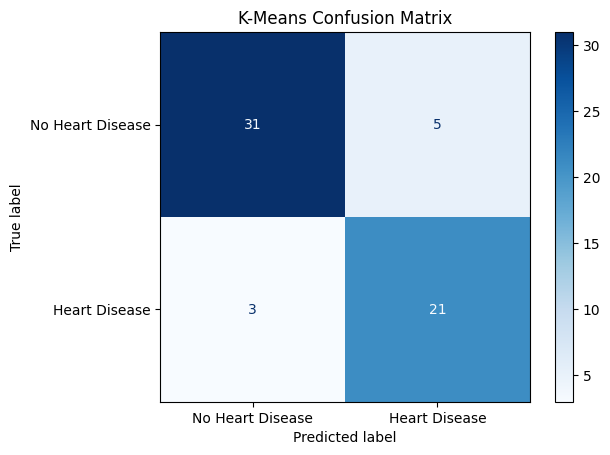

In [16]:
# Set up train test Split

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_data, labels.astype(int), test_size=0.2, random_state=42
)

# Create base XGBOOST classifier model

base_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Set up ranges of hyperparameters to test

param_grid = {
    'n_estimators': [100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'gamma': [0, 1]
}

# Perform grid search over hyperparameters to find best accuracy

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',      
    cv=3,                    
    verbose=1,
    n_jobs=-1                
)

grid_search.fit(X_train, y_train)

# Display best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2%}")

# Set up tuned XGBOOST model and predict on test set

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Final XGBoost accuracy on test set: {acc:.2%}")
cm = confusion_matrix(y_test, y_pred)

class_names = ['No Heart Disease', 'Heart Disease']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)


disp.plot(cmap='Blues')
plt.title("K-Means Confusion Matrix")
plt.show()
